# Inland Water and Coastal Monitoring.

This notebook tries to use Sentinel 1 data to extract a time series of water detection for a given area of interest.

As per the title, there are two major functions to this app. The first is inland water detection and monitoring, while the second is coastal monitoring. Several sections require switching "on" and "off" to change between the two and are signposted as such, relevant instructions are given at these sections. 

The original app 'Coastline Compare' was developed by Wil Selwood. The alterations that created 'Inland Water and Coastal Monitoring' were authored by Jonathan Hicks with greatly appreciated help from Wil Selwood, Tom Jones, Michael Young and Ella Buhner Gattis. All work was done in house at Satellite Applications Catapult.

### FIRST TIME USE
Create a folder in the same directory called "Inland_water_monitoring" for the files to export to.

In [277]:
# imports needed for the rest of the notebook.

import numpy as np
import pandas as pd
import collections
import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray
import scipy
import datacube
from shapely.geometry import MultiLineString, mapping
from skimage.measure import find_contours
from datacube.storage import masking
from matplotlib import cm
#from utils.data_cube_utilities.dc_display_map import display_map

# added the following imports 
import csv
from collections import defaultdict


In [278]:
import dask
from dask.distributed import Client
client = Client('dask-scheduler.dask.svc.cluster.local:8786')
client
print('done')

done


## Defining the Area Of Interest (AOI)
First select the timespan under "time" and the time step, this can be a week or longer given the revisit time of Sentinel 1.

Then either select a pre-selected AOI or create a new one with the same parameters. X/Y min/max are in EPSG:32760 while Lon/Lat are in EPSG:4326.

In [283]:
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>CHANGE HERE    
# Available time for current S1 data as of V3 - 5th Aug 2019 = 2018-04-02 to 2019-03-28
# time = ("2018-04-02", "2019-06-01")
time = ("2018-04-30", "2019-04-30")
# time = ("2018-03-02", "2019-03-01")
# How often to extract coast line polygons. W = week, M = month
# time_step = '4D'
# time_step = '1W'
time_step = '12M'
# time_step = '4M'


# River Example - Sigatoka River
#longitude = (177.74, 177.92)
#latitude = (-17.95, -17.82)
#xmin = 578362.16
#xmax = 597495.37
#ymin = 8015190.29
#ymax = 8029489.22

# Reservoir Example - Vaturu Dam
longitude = (177.6394, 177.6837)
latitude = (-17.7574, -17.7074)
xmin = 567781.67
xmax = 572498.12
ymin = 8036539.09
ymax = 8042054.53

# Lake Example - Central Region Lake
#longitude = (177.96, 178.15)
#latitude = (-17.8, -17.65)
#xmin = 601745.96
#xmax = 621986.65
#ymin = 8031680.87
#ymax = 8048165.18

# South East Coast - Suva
# longitude = (178.3815, 178.7522)
# latitude = (-18.1938, -17.9991)
# xmin = 646100.09
# xmax = 685516.98
# ymin = 7987822.93
# ymax = 8009037.29

# South East - Naqali
# longitude = (178.34, 178.44)
# latitude = (-17.91, -17.99)
# xmin = 641938.26
# xmax = 652463.84
# ymin = 8010329.00
# ymax = 8019261.17

# Coastline Example - South Coast
# longitude = (177.481, 177.855)
# latitude = (-18.00, -18.3732)
# xmin = 550920.41
# xmax = 590322.94
# ymin = 8009748.41
# ymax = 7968311.82

# Coastline Example 2 - South West Coast
# longitude = (177.39, 177.54)
# latitude = (-18.11, -18.19)
# xmin = 541261.01
# xmax = 557104.97
# ymin = 7988709.38
# ymax = 7997600.76

# Coastline Example 3 - Nadi - West Coast#
#longitude = (177.35, 177.50)
#latitude = (-17.81, -17.72)
#xmin = 537110.14
#xmax = 552988.26
#ymin = 8027433.48
#ymax = 8030764.40

# Viti Levu, the whole island
#longitude = (177.1594, 178.7222)
#latitude = (-18.2962, -17.2867)
#xmin = 516846.12
#xmax = 683058.38
#ymin = 7977036.18
#ymax = 8087910.63

# Natewa Bay - this area must not be in the cube yet - but an interesting one for coastal erosion
#longitude = (179.5028, 179.4616)
#latitude = (-16.7415, -16.7747)
#xmax = 766839.91
#xmin = 762399.46
#ymax = 8147361.60
#ymin = 8143740.97


x = (xmin, xmax)
y = (ymin, ymax)

ar=abs((longitude[1]-longitude[0])/(latitude[1]-latitude[0]))

In [284]:
# display_map(latitude=y, longitude=x)
#display_map(latitude=latitude, longitude=longitude)

## Define Threshold
Alter the detection threshold of water, this generally works best as lower for inland (30 or 10) and higher (90) for coasts.

In [285]:
# percentage of total of images in a time window that need to be water to include in the output.

# >>>>>>>>>>>>>>>>>>>>>> CHANGE HERE 
# threshold = 10
# threshold = 30
threshold = 70
# threshold = 90 
# Don't change these detection parameters
min_vertices = 100
# water settings in sar
vv_threshold = 12
vh_threshold = -15.5

# tuneable parameters 
output_shp = f's1_land_water-{threshold}.shp' # output filename

## Define Resolution
For smaller areas such as the reservoir example, use the smaller resolution (15, 15) value for better results. For coasts, a higher resolution value is recomended.

In [286]:
# Do the query to get the data. This may take a while, depending on your aoi settings.
# query parameters 
res = (15,15)
# res = (30,30)
# res = (50,50)
# Changed to the standard crs used in the dcal folder, as well as %env to allow access
# 'output_crs' : "EPSG:4326" OR 'output_crs': 'EPSG:32760'
crs = "EPSG:32760"
%env AWS_NO_SIGN_REQUEST=YES

query=({'x':x,
        'y':y,
        'time': time,
        'crs':crs,
        'output_crs': 'EPSG:32760',
        'resolution':res
        })

dc = datacube.Datacube(app="s1_coastline")

# load up the data and filter down to water, with the product now named s1g rather than s1
s1_coverage = dc.load(product="s1g_gamma0_scene", **query)

env: AWS_NO_SIGN_REQUEST=YES


In [287]:
# find w/ query
len(dc.find_datasets(product='s1g_gamma0_scene', **query))

80

In [288]:
# find with working query
dss = dc.find_datasets(product = 's1g_gamma0_scene', **query)
len(dss)

80

In [289]:
# load w/ working query
s1 = dc.load(product = 's1g_gamma0_scene', **query)

In [290]:
s1_coverage = masking.mask_invalid_data(s1)

In [291]:
s1_coverage
print('done')

done


## Apply Speckle Filter

In [292]:
s1_coverage_clean = s1_coverage.where(s1_coverage!=0)

In [293]:
s1_coverage_clean

<xarray.Dataset>
Dimensions:  (time: 80, x: 315, y: 368)
Coordinates:
  * time     (time) datetime64[ns] 2018-05-03T06:39:54 ... 2019-03-28T17:40:44
  * y        (y) float64 8.037e+06 8.037e+06 8.037e+06 ... 8.042e+06 8.042e+06
  * x        (x) float64 5.678e+05 5.678e+05 5.678e+05 ... 5.725e+05 5.725e+05
Data variables:
    vh       (time, y, x) float32 -13.859803 -13.859803 ... -13.284379
    vv       (time, y, x) float32 -7.536191 -7.536191 ... -3.9997907 -3.9997907
Attributes:
    crs:      EPSG:32760

In [294]:
# Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

def lee_filter(da, size):
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

In [295]:
# lee filter implemnation doesn't consider nan

# save the nodata mask
nodata_mask = s1_coverage_clean.isnull().to_array().any(axis=0)
# replace nan with 0
s1_coverage_zerofilled = s1_coverage.where(~s1_coverage.isnull(), 0)
s1_coverage_zerofilled

<xarray.Dataset>
Dimensions:  (time: 80, x: 315, y: 368)
Coordinates:
  * time     (time) datetime64[ns] 2018-05-03T06:39:54 ... 2019-03-28T17:40:44
  * y        (y) float64 8.037e+06 8.037e+06 8.037e+06 ... 8.042e+06 8.042e+06
  * x        (x) float64 5.678e+05 5.678e+05 5.678e+05 ... 5.725e+05 5.725e+05
Data variables:
    vh       (time, y, x) float32 -13.859803 -13.859803 ... -13.284379
    vv       (time, y, x) float32 -7.536191 -7.536191 ... -3.9997907 -3.9997907
Attributes:
    crs:      EPSG:32760

In [296]:
smoothed_vv=s1_coverage_zerofilled.vv.groupby('time').apply(lee_filter, size=7)
smoothed_vh=s1_coverage_zerofilled.vh.groupby('time').apply(lee_filter, size=7)

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [297]:
smoothed=smoothed_vv.to_dataset(name='vv')
smoothed['vh']=smoothed_vh

In [298]:
# put nodata back
smoothed=smoothed.where(~nodata_mask)

In [299]:
clean=smoothed.copy()
clean['vv'] =clean.vv.where(~clean.vv.isnull(), 1000)
clean['vh'] =clean.vh.where(~clean.vh.isnull(), 1000)
print("# of negative pixels in vv vh:", (clean.vv<0).sum().values, (clean.vh<0).sum().values)
#visual check
#(clean.vh<0).any(dim='time').plot()
clean['vv'] =clean.vv.where(clean.vv>0, 1e-3)
clean['vh'] =clean.vh.where(clean.vh>0, 1e-4)
clean=clean.where(clean<1000)

# of negative pixels in vv vh: 6143386 6143639


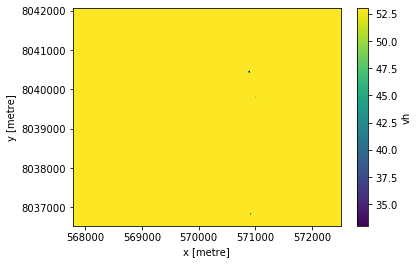

In [300]:
# number of valid observations
clean.vh.count(dim='time').plot()

In [301]:
clean['vv_plus_vh']=clean.vh+clean.vv
clean['vh_over_vv']=clean.vh/clean.vv

In [302]:
clean

<xarray.Dataset>
Dimensions:     (time: 80, x: 315, y: 368)
Coordinates:
  * y           (y) float64 8.037e+06 8.037e+06 ... 8.042e+06 8.042e+06
  * x           (x) float64 5.678e+05 5.678e+05 ... 5.725e+05 5.725e+05
  * time        (time) datetime64[ns] 2018-05-03T06:39:54 ... 2019-03-28T17:40:44
Data variables:
    vv          (time, y, x) float32 0.001 0.001 0.001 ... 0.001 0.001 0.001
    vh          (time, y, x) float32 1e-04 1e-04 1e-04 ... 1e-04 1e-04 1e-04
    vv_plus_vh  (time, y, x) float32 0.0011 0.0011 0.0011 ... 0.0011 0.0011
    vh_over_vv  (time, y, x) float32 0.099999994 0.099999994 ... 0.099999994

### Switch Filter On or Off
This will decide whether the output is cleared of smaller detections, particularly useful if looking simply at water/land identification with the open threshold detection. If looking for soil moisture or the like, it is recommended to switch the filter off as much of the smaller detections is difficult to distinguish from noise in the filter.

In [303]:
# Filter On
# s1_coverage['Observations'] = ((smoothed_vv <= vv_threshold) & (smoothed_vh <= vh_threshold))

# Filter Off
s1_coverage['Observations'] = ((s1_coverage["vv"] <= vv_threshold) & (s1_coverage["vh"] <= vh_threshold))

s1_coverage['Observations']
print('done')

done


## Definitions


In [304]:
# define save polygon function
def save_poly(output_geojson, crs, polygon):
    
    attribute_data = {} 
    attribute_dtypes = {} 
    schema = {'geometry': 'MultiLineString',
          'properties': attribute_dtypes}
    
    with fiona.open(output_geojson, 'w',
                crs={'init': str(crs), 'no_defs': True},
                driver='GeoJSON',
                schema=schema) as output:

        # Create multi-string object from all contour coordinates
        contour_multilinestring = MultiLineString(polygon)

        # Get attribute values for writing
        attribute_vals = {field_name: field_vals[i] for field_name, field_vals in 
                          attribute_data.items()}

        # Write output shapefile to file with z-value field
        output.write({'properties': attribute_vals,
                      'geometry': mapping(contour_multilinestring)})

In [305]:
def extract_contour(data_source, data, threshold, min_vertices):
    ds_affine = data_source.geobox.transform
    ps = ds_affine[0]  # Compute pixel size

    contours_geo = [np.column_stack(ds_affine * (i[:, 1], i[:, 0])) + np.array([0.5 * ps, -0.5 * ps]) for i in
                    find_contours(data, threshold)]
    contours_nona = [i[~np.isnan(i).any(axis=1)] for i in contours_geo]
    contours_withdata = [i for i in contours_nona if len(i) >= min_vertices]
    return contours_withdata

# Define Water Source 

Here the main selection between coastal and inland monitoring occurs. Uncomment the choice you wish to make.

The first choice is between a thresholded image and a full range:
 - The Thresholded Images are better for simple water identification and tracking the extent of inland bodies of water and coastlines due to the larger contrast between water and non water detection.
 - The Full Range Images pick up surface water and as such are better for infering precipitation and river volume and discharge.
 
The second choice is whether your AOI is a coastal region or an inland body of water. The coastlines option will be processed later in the code to produce a timelapse of the coastline boundary change, while the inland water option will lead to the production of a timelapse of the detection map produced here.

0 t: 3.5 m: 5
2018-05-31T00:00:00.000000000
1 t: 33.6 m: 48
2019-05-31T00:00:00.000000000


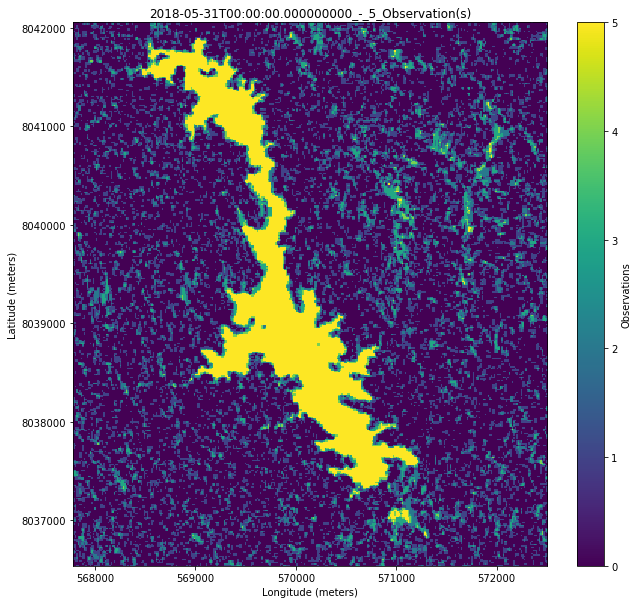

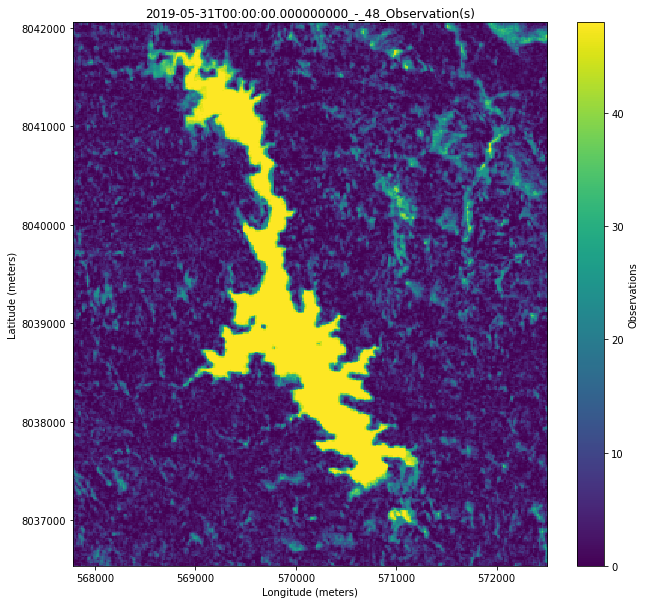

In [306]:
chunks = s1_coverage['Observations'].resample(time=time_step).sum('time')
for t in range(0, chunks.time.size):
    layer = chunks.isel(time=t)
    layer_max = layer.max().values
    layer_threshold = (layer_max / 100 ) * threshold
    print(f"{t} t: {layer_threshold} m: {layer_max}")
    print(layer.time.values)
    
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>CHANGE HERE   

# Threshold Images 
#     layer.where(layer > layer_threshold).plot.imshow(figsize=(12*ar,10))
# Full Range Images    
    layer.where(layer_max > layer_threshold).plot.imshow(figsize=(12*ar,10))
    
    plt.title(f"{layer.time.values}_-_{layer_max}_Observation(s)")
    plt.xlabel("Longitude (meters)")
    plt.ylabel("Latitude (meters)")
    contour = extract_contour(s1_coverage, layer, layer_threshold, min_vertices)
# Coastline Monitoring  
#    save_poly(f"Inland_water_monitoring/Coastline_{t}.geojson", s1_coverage.crs, contour)
# Inland Water Monitoring        
    #plt.savefig(f"Inland_water_monitoring/Inland_{layer.time.values}.jpg")

In [307]:
for t in chunks.time:
    print(t.values)

2018-05-31T00:00:00.000000000
2019-05-31T00:00:00.000000000


In [308]:
print(chunks)

<xarray.DataArray 'Observations' (time: 2, y: 368, x: 315)>
array([[[ 0,  0, ...,  0,  0],
        [ 0,  0, ...,  0,  0],
        ...,
        [ 0,  0, ...,  0,  1],
        [ 0,  0, ...,  0,  1]],

       [[ 4,  3, ...,  2,  4],
        [ 2,  0, ...,  3,  7],
        ...,
        [ 7,  2, ...,  2,  6],
        [12,  1, ...,  9,  6]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-05-31 2019-05-31
  * y        (y) float64 8.037e+06 8.037e+06 8.037e+06 ... 8.042e+06 8.042e+06
  * x        (x) float64 5.678e+05 5.678e+05 5.678e+05 ... 5.725e+05 5.725e+05


In [309]:
print(layer)

<xarray.DataArray 'Observations' (y: 368, x: 315)>
array([[ 4,  3,  4, ...,  8,  2,  4],
       [ 2,  0,  0, ...,  6,  3,  7],
       [ 0,  0,  2, ...,  8, 11, 20],
       ...,
       [ 4,  2,  3, ...,  4,  3,  6],
       [ 7,  2,  1, ...,  0,  2,  6],
       [12,  1,  6, ...,  3,  9,  6]])
Coordinates:
    time     datetime64[ns] 2019-05-31
  * y        (y) float64 8.037e+06 8.037e+06 8.037e+06 ... 8.042e+06 8.042e+06
  * x        (x) float64 5.678e+05 5.678e+05 5.678e+05 ... 5.725e+05 5.725e+05


## Coastline Compilation Tool
Unlike the inland water tool which simply uses jpg images, the coastline boundaries are stored as geojson files in alphabetical order, the following code converts these into index ordered jpg images and adds graph features such as titles. If you are using an inland AOI, this section will output blank maps and can be ignored. 

(As of V4 (Aug 2019) long time ranges still produce a lot of copies due to the for loops.)

In [197]:
#for t in range(chunks.time.size):
#     for i, t in enumerate(chunks.time):
#         t = t.values
#         print(i)
#         print(t)
#         gdf = gpd.read_file(f"Inland_water_monitoring/Coastline_{i}.geojson")
#         for i in gdf.geometry[:1]: 
#             gdf.plot()
#             plt.title(f"{t}")
#             plt.xlabel("Longitude (meters)")
#             plt.ylabel("Latitude (meters)")
#             plt.xlim([xmin,xmax]) 
#             plt.ylim([ymin,ymax])
#             plt.tight_layout()
#             #plt.savefig(f"Inland_water_monitoring/Coastline_Map_{t}.jpg")
#             plt.show()

# Timelapse (GIF) Generator
This code collects the jpg images in order and produces the timelapse GIF. Select the correct option for the AOI in use for each of these two highlighted areas.

The code may require "pip install opencv-python" in Terminal if "ModuleNotFoundError: No module named 'cv2'" produced.

In [198]:
import cv2
import glob
from PIL import Image

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>CHANGE HERE
# Credit to original app author Wil Selwood for the following code in creating the GIF image 
# gif = glob.glob("Inland_water_monitoring/Coastline_Map_*.jpg")
# OR
gif = glob.glob("Inland_water_monitoring/Inland_*.jpg")

gif.sort()
print(gif)

img = [None]*len(gif)
for t, p in enumerate(gif):
    img[t] = Image.open(p)

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>CHANGE HERE
# Credit to Ella Buhner Gattis for the basis of the following code in creating the GIF image    
# img[0].save('Inland_water_monitoring/Coastline_Map_Timelapse.gif', save_all=True, append_images=img[1:],loop=0,duration=1000)
# OR
img[0].save('Inland_water_monitoring/Inland_Map_Timelapse.gif', save_all=True, append_images=img[1:],loop=0,duration=1000)

ModuleNotFoundError: No module named 'cv2'